In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import os
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_21578/2544869563.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# check version number
import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools

imblearn version:  0.12.0


In [3]:
binding_path = 'data/NEK_data_4Berkeley/NEK2/'
nek2_binding_random_imbalanced = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df_binding = pd.read_csv(binding_path+nek2_binding_random_imbalanced)
all_fold_df_binding.shape # (1408,310)

#inhibition
inhibition_path = 'data/NEK_data_4Berkeley/NEK2/'
inhibition_moe = 'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
all_fold_df_inhibition = pd.read_csv(inhibition_path+inhibition_moe)
all_fold_df_inhibition.shape  # (2044, 310)

(2044, 310)

In [8]:
combined_df = pd.concat([all_fold_df_binding, all_fold_df_inhibition ])
value_counts = combined_df[('compound_id')].value_counts()
value_counts
in_both = value_counts[value_counts==2]
in_both

compound_id
kdb_244     2
kdb_2207    2
kdb_1514    2
kdb_1003    2
kdb_1649    2
           ..
kdb_67      2
kdb_123     2
kdb_114     2
kdb_2206    2
kdb_2221    2
Name: count, Length: 112, dtype: int64

In [4]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
data_path = 'data/datasets/scaled_descriptors/'
binding_file = 'NEK2_1_uM_min_50_pct_inhibition_with_moe_descriptors.csv'
binding_df = pd.read_csv('data/datasets/scaled_descriptors/NEK2_1_uM_min_50_pct_inhibition_with_moe_descriptors.csv')
# print(binding_df.shape)
moe_columns = binding_df.columns[3:]
moe_columns

Index(['ASA+_per_atom', 'ASA-', 'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom',
       'BCUT_PEOE_0', 'BCUT_PEOE_1', 'BCUT_PEOE_2', 'BCUT_PEOE_3',
       'BCUT_SLOGP_0_per_atom',
       ...
       'vsurf_Wp2_per_atom', 'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5',
       'vsurf_Wp6', 'vsurf_Wp7', 'vsurf_Wp8', 'weinerPath',
       'weinerPol_per_atom', 'zagreb_per_atom'],
      dtype='object', length=306)

In [10]:
# list(moe_columns)

In [5]:
inhibition_df = pd.read_csv('data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv') 
inhibition_df.shape

(2044, 310)

In [7]:
split_path = 'NEK_data_4Berkeley/NEK2/'
random_inhibition_file = 'NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv'
random_inhibition_df = pd.read_csv('data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_inhibition_5fold_random_imbalanced.csv')

In [13]:
print(random_inhibition_df['fold'].unique())
print(random_inhibition_df['fold'].value_counts())
print(random_inhibition_df.columns)
print(f"inactive: {random_inhibition_df[random_inhibition_df['active'] == 0].shape[0]}")

print(f"active: {random_inhibition_df[random_inhibition_df['active'] == 1].shape[0]}")

['fold4' 'fold1' 'fold2' 'fold3' 'fold5']
fold
fold4    409
fold1    409
fold2    409
fold3    409
fold5    408
Name: count, dtype: int64
Index(['compound_id', 'base_rdkit_smiles', 'active', 'ASA+_per_atom', 'ASA-',
       'ASA_H_per_atom', 'ASA_P', 'ASA_per_atom', 'BCUT_PEOE_0', 'BCUT_PEOE_1',
       ...
       'vsurf_Wp3', 'vsurf_Wp4', 'vsurf_Wp5', 'vsurf_Wp6', 'vsurf_Wp7',
       'vsurf_Wp8', 'weinerPath', 'weinerPol_per_atom', 'zagreb_per_atom',
       'fold'],
      dtype='object', length=310)
inactive: 1904
active: 140


In [16]:
test_random_inhibition_df = random_inhibition_df.loc[random_inhibition_df['fold'] == "fold1"]
train_random_inhibition_df = random_inhibition_df.loc[random_inhibition_df['fold'] != "fold1"]
print(test_random_inhibition_df.shape)
print(train_random_inhibition_df.shape)

(409, 310)
(1635, 310)


In [17]:
test_x_df = test_random_inhibition_df[moe_columns]
test_y_df = test_random_inhibition_df['active']
train_x_df = train_random_inhibition_df[moe_columns]
train_y_df = train_random_inhibition_df['active']

print(train_y_df.value_counts()) 
print(test_y_df.value_counts())


active
0    1523
1     112
Name: count, dtype: int64
active
0    381
1     28
Name: count, dtype: int64


In [18]:
uq_path = 'data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(uq_path+'NEK2_inhibition_random_fold1_trainX.csv')
train_y_df= pd.read_csv(uq_path+"/NEK2_inhibition_random_fold1_trainY.csv")
test_x_df= pd.read_csv(uq_path+"/NEK2_inhibition_random_fold1_testX.csv")
test_y_df= pd.read_csv(uq_path+"/NEK2_inhibition_random_fold1_testY.csv")
print(train_y_df.value_counts()), print(test_y_df.value_counts())
print(train_y_df.shape, test_y_df.shape)

active
0         1523
1          112
Name: count, dtype: int64
active
0         381
1          28
Name: count, dtype: int64
(1635, 1) (409, 1)


In [19]:
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()

scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 
    
# Set the n_components=3
# 95% variance 
principal=PCA(n_components=0.95) 
principal.fit(Scaled_data)
pca_train_x_df=principal.transform(train_scaled_data)
pca_test_x_df=principal.transform(test_scaled_data)

print(pca_train_x_df.shape)
print(pca_test_x_df.shape)

(1635, 66)
(409, 66)


In [20]:
# SMOTE

# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
# SMOTE: creating synthetic examples of minority class 
new_train_x_df, new_train_y_df = oversample.fit_resample(pca_train_x_df, train_y_df)

In [21]:
#  Transform data to PyTorch tensors

# PCA then SMOTE
train_x_temp = new_train_x_df.astype("long")
train_y_temp = new_train_y_df.to_numpy().astype("long")

# PCA
test_x_temp = pca_test_x_df.astype("long")


test_y_temp = test_y_df.to_numpy().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp.reshape(-1))
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp.reshape(-1))

print(train_x.shape)
print(train_y.shape)


torch.Size([3046, 66])
torch.Size([3046])


In [22]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [23]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 300


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/300 - Loss: 7.011   lengthscale: 0.693   noise: 0.693
Iter 6/300 - Loss: 6.249   lengthscale: 0.975   noise: 0.971
Iter 11/300 - Loss: 5.673   lengthscale: 1.319   noise: 1.280
Iter 16/300 - Loss: 5.230   lengthscale: 1.726   noise: 1.557
Iter 21/300 - Loss: 4.893   lengthscale: 2.194   noise: 1.722
Iter 26/300 - Loss: 4.633   lengthscale: 2.703   noise: 1.741
Iter 31/300 - Loss: 4.401   lengthscale: 3.229   noise: 1.620
Iter 36/300 - Loss: 4.207   lengthscale: 3.749   noise: 1.391
Iter 41/300 - Loss: 4.034   lengthscale: 4.238   noise: 1.106
Iter 46/300 - Loss: 3.901   lengthscale: 4.681   noise: 0.816
Iter 51/300 - Loss: 3.784   lengthscale: 5.071   noise: 0.564
Iter 56/300 - Loss: 3.678   lengthscale: 5.408   noise: 0.371
Iter 61/300 - Loss: 3.607   lengthscale: 5.697   noise: 0.241
Iter 66/300 - Loss: 3.555   lengthscale: 5.942   noise: 0.160
Iter 71/300 - Loss: 3.523   lengthscale: 6.150   noise: 0.111
Iter 76/300 - Loss: 3.498   lengthscale: 6.326   noise: 0.082
Iter 81/30

In [24]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(train_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(train_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


(2, 3046)
tensor([0, 0, 0,  ..., 1, 1, 1])


Confusion matrix, without normalization
[[1515    8]
 [   1 1522]]


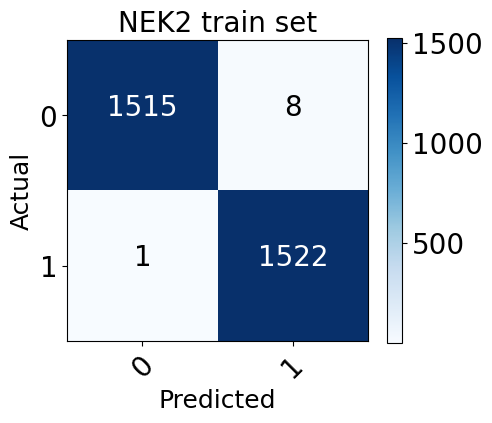

In [25]:
train_prediction = model(train_x).loc.max(0)[1].numpy()
y_true = new_train_y_df.values
y_pred = train_prediction
train_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [30]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    observed_pred = likelihood(model(test_x))
    
print(pred_means.numpy().shape)
print(pred_means.max(0)[1])

(2, 409)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0,

In [31]:
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(409,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Confusion matrix, without normalization
[[374   7]
 [ 12  16]]


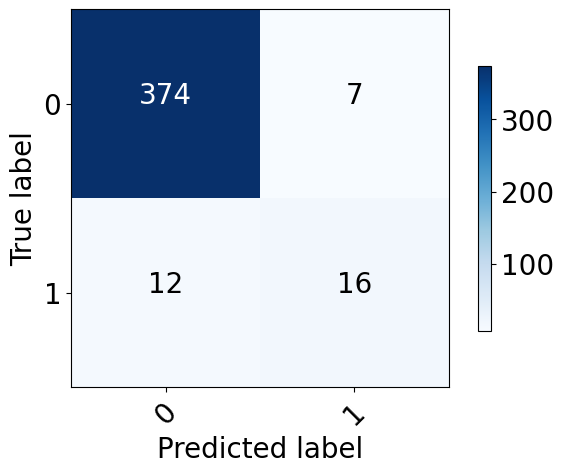

In [35]:
cm = confusion_matrix(test_y_df.values, test_prediction)

classes = ['0', '1']

plot_confusion_matrix(cm, classes)
plt.show()

Confusion matrix, without normalization
[[374   7]
 [ 12  16]]


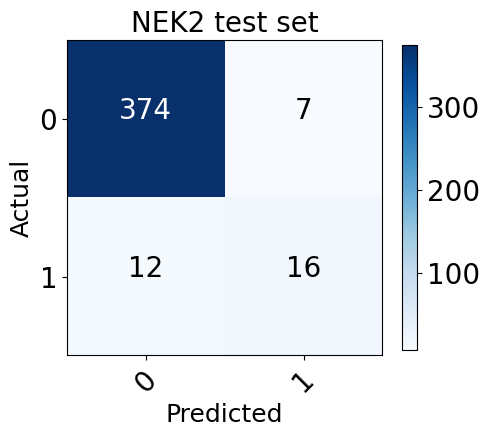

In [32]:
y_true = test_y_df.values
y_pred = test_prediction
test_cm = confusion_matrix(y_true, y_pred)
class_names = ["0","1"]

plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [33]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 2.0531,  1.8634,  1.6386,  1.0237,  1.9316,  1.7780,  1.6448,  2.7069,
          2.3533,  1.5191,  2.3653,  2.5162,  1.5317,  2.6377,  1.8342,  1.0966,
          2.5759,  1.9429,  2.4366,  0.4738,  1.5161,  2.8969,  0.3823,  2.1495,
          2.2847,  2.3711,  2.0177,  1.7720,  1.2750,  1.6192,  2.4529,  0.5589,
          2.2474,  0.6991,  1.3432,  2.4347,  2.4333,  2.1543,  2.2171,  2.3004,
         -0.1520,  2.2757,  2.3687,  1.9170,  1.6975,  1.7460,  1.8268,  1.8264,
          0.8437, -1.2956,  2.0093,  1.8416,  2.1439,  1.6176,  1.9538,  1.7684,
          1.1567,  2.2643,  2.3766,  2.4485,  2.2848,  1.7712,  2.6789,  2.2705,
          1.9952,  0.9924,  1.7988,  2.5093,  1.7619,  2.1877,  2.4960,  2.0010,
          0.7697,  1.7432,  2.4702,  1.0858, -1.9166,  2.1047,  2.5411,  2.4858,
          2.6828,  2.2397,  1.4645,  1.6135,  2.6491,  2.2480,  2.5363,  3.0279,
          2.7007,  2.4419,  2.5098,  1.4556,  0.8660,  2.3386,  1.5686,  1.5149,
          1.1264,  1.8909,  

In [34]:
observed_pred.mean.numpy()

array([[-3.65290821e-01, -7.09954917e-01, -2.77411163e-01,
        -1.07431817e+00, -2.82231510e-01, -7.84743249e-01,
        -5.31273544e-01, -1.15089655e-01, -2.23355711e-01,
        -1.26308393e+00, -1.27039254e-01, -1.78931415e-01,
        -3.72042358e-01, -1.97962359e-01, -6.80528224e-01,
        -1.20366025e+00, -2.33387575e-01, -7.92413950e-01,
        -1.82981670e-01, -1.91463590e+00, -1.18099666e+00,
         1.84769213e-01, -1.44712901e+00, -4.00583416e-01,
        -3.53374898e-01, -3.39126289e-01, -4.48680341e-01,
        -4.24839437e-01, -1.09573185e+00, -3.84473503e-01,
        -3.63407165e-01, -1.93063688e+00, -5.59512317e-01,
        -1.75317407e+00, -5.78015506e-01, -3.04399073e-01,
        -4.11371976e-01, -2.21675575e-01, -2.33320057e-01,
        -2.24781454e-01, -2.51589704e+00, -1.93367839e-01,
        -3.47064942e-01,  1.40027821e-01, -4.64669168e-01,
        -1.49663627e-01,  5.45139909e-02, -4.02221084e-02,
        -1.58734226e+00, -3.32143950e+00, -5.57654679e-0

In [51]:
print(observed_pred.variance.numpy().shape)
observed_pred.variance.numpy()

(2, 283)


array([[1.6080365 , 1.7258031 , 1.722547  , 1.733978  , 1.6894143 ,
        1.7277446 , 1.751997  , 1.1078259 , 1.6152217 , 1.7458154 ,
        1.7311641 , 1.7119017 , 1.7524768 , 1.7287016 , 1.20453   ,
        1.7535381 , 1.6047035 , 1.6994399 , 1.6279547 , 1.575781  ,
        1.7509732 , 1.6962113 , 1.2047267 , 1.6745958 , 1.7271354 ,
        1.3377223 , 1.3266654 , 1.7463734 , 1.5823244 , 1.4594831 ,
        1.5471078 , 1.6497241 , 1.7189528 , 1.7251946 , 1.7280121 ,
        1.7414677 , 1.4515147 , 1.7527758 , 1.7375165 , 1.1245022 ,
        1.6056304 , 1.747114  , 1.7351716 , 1.7522563 , 1.7128606 ,
        1.6899242 , 1.5587143 , 1.7270778 , 1.65323   , 1.7304196 ,
        1.5221274 , 1.7136564 , 1.6965994 , 1.5831627 , 1.7440356 ,
        1.7534902 , 1.7363719 , 1.0710099 , 1.6836554 , 1.6593465 ,
        1.6825418 , 1.7518717 , 1.6999005 , 1.6509863 , 1.4307544 ,
        1.7022696 , 1.7464169 , 1.7379916 , 1.7344978 , 1.6497399 ,
        1.6543621 , 1.7527508 , 1.6762116 , 1.74

In [52]:
print(pred_means.numpy())

[[-0.9169748  -0.5756091  -0.21670736 -0.14453351 -0.03793894  0.12064491
  -0.26215255 -0.27261207 -2.0240126  -0.17729658 -0.62531304 -0.16721712
  -0.22953194 -0.24977061 -0.5022064  -0.1861976   0.11359809 -0.40554768
  -0.70184475 -0.08476047 -0.31048822 -0.85477    -0.29287755  0.0085278
  -0.1815524  -3.0792677  -0.34130108 -0.39413178 -0.48102874 -1.7276139
  -0.7222028  -0.04087542 -0.52156717 -0.25462225 -0.5421943  -0.00970979
  -0.40997577 -0.3198937  -0.16045685 -0.31847334 -1.2275294  -0.3477311
  -0.5171787  -0.19887912 -0.35638246 -1.1158919  -0.275571   -0.6679631
  -0.14163278 -0.23312911 -1.668069   -0.27362    -0.34585458 -0.7251827
  -0.47250813 -0.18784893 -0.58436507 -0.63423574 -0.35087955 -0.11766373
  -0.5401318  -0.2076764  -0.3176313  -0.53450656 -0.7946921  -0.29704446
  -0.27685478 -0.1350393  -0.662708   -0.20421605 -1.5679889  -0.24347693
  -0.13596497 -0.37605068 -1.7571781  -0.6396743  -0.6145855  -0.18657064
  -0.3051371  -0.42728305 -0.7213652  -0.27

In [53]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities

tensor([[0.9705, 0.9750, 0.9905, 0.9937, 0.9957, 0.9965, 0.9934, 0.9972, 0.8067,
         0.9953, 0.9674, 0.9953, 0.9883, 0.9944, 0.9920, 0.9925, 0.9979, 0.9909,
         0.9572, 0.9974, 0.9924, 0.9691, 0.9964, 0.9957, 0.9934, 0.5268, 0.9928,
         0.9894, 0.9652, 0.8372, 0.9816, 0.9963, 0.9781, 0.9937, 0.9804, 0.9958,
         0.9932, 0.9894, 0.9917, 0.9969, 0.9224, 0.9927, 0.9779, 0.9933, 0.9929,
         0.9313, 0.9861, 0.9691, 0.9928, 0.9929, 0.8978, 0.9878, 0.9861, 0.9691,
         0.9861, 0.9923, 0.9836, 0.9865, 0.9895, 0.9934, 0.9787, 0.9948, 0.9887,
         0.9671, 0.9691, 0.9923, 0.9924, 0.9955, 0.9774, 0.9948, 0.8743, 0.9929,
         0.9962, 0.9821, 0.8021, 0.9756, 0.9742, 0.9942, 0.9907, 0.9859, 0.9772,
         0.9935, 0.9707, 0.3146, 0.9826, 0.9919, 0.9950, 0.9879, 0.9034, 0.9914,
         0.9937, 0.9813, 0.8405, 0.9935, 0.9868, 0.9798, 0.9793, 0.9876, 0.9894,
         0.9958, 0.9906, 0.9834, 0.9910, 0.9940, 0.9906, 0.9037, 0.7003, 0.9867,
         0.9035, 0.9752, 0.9